In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import warnings
warnings.filterwarnings("ignore")

#Import all libraries

In [17]:
#Import all libraries which is required for project tasks
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.types import Device
from tqdm import tqdm  # For nice progress bar!
import matplotlib.pyplot as plt 
import sklearn.metrics #for F1 score, precision, recall

import PIL
from PIL import Image
import torchvision
from torchvision import datasets, transforms, utils
from torchvision.datasets import ImageFolder


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#X-ray chest images

In [18]:
root_dir = '/content/drive/MyDrive/DATASET_FINAL/images' #root which contents all images in RGB
csv_dir = '/content/drive/MyDrive/DATASET_FINAL/x_ray_new.csv' #root to csv file which content in 0 column images name and in 1 column class

#Data Loader

In [19]:
class XRayChestDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform
  
  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
 #   image = io.imread(img_path)
    image = Image.open(img_path).convert('RGB')
    y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

    if self.transform:
      image = self.transform(image)

    return (image, y_label)

In [20]:
#transform rule for data
preprocess = transforms.Compose([
  #do size 64 to 64 to make computations faster for computer
  transforms.Resize(size=(64, 64)),
  #do transform.ToTensor for dataset in pytorch
  transforms.ToTensor(),
  transforms.RandomRotation(degrees = 5),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
  ])

#Dataset which we are gonna working with
dataset = XRayChestDataset(csv_file = csv_dir, root_dir = root_dir, transform = preprocess)

#split data to 70/20/10 sets
number_of_images = len(dataset)

number_of_images_train = int(number_of_images*0.7)
number_of_images_test = int(number_of_images*0.2)
number_of_images_valid = number_of_images - number_of_images_train - number_of_images_test

train_set, test_set, valid_set = torch.utils.data.random_split(dataset, [number_of_images_train,
                                                                         number_of_images_test,
                                                                         number_of_images_valid])

In [21]:
#hint: DO NOT USE JUPYNER NOTEBOOK! IT DOSENT SUPPORT multiprocess. There is a lag when num_workers > 0!
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=64, shuffle=False, num_workers=2)
valid_loader = torch.utils.data.DataLoader(dataset=valid_set, batch_size=1, num_workers = 2) 

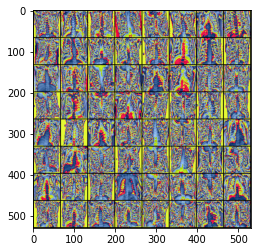

NORMAL PNEUMONIA PNEUMONIA PNEUMONIA NORMAL PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA NORMAL NORMAL NORMAL PNEUMONIA PNEUMONIA NORMAL NORMAL PNEUMONIA NORMAL NORMAL PNEUMONIA PNEUMONIA NORMAL NORMAL NORMAL PNEUMONIA NORMAL PNEUMONIA NORMAL NORMAL PNEUMONIA NORMAL PNEUMONIA PNEUMONIA PNEUMONIA NORMAL PNEUMONIA NORMAL NORMAL PNEUMONIA NORMAL PNEUMONIA NORMAL PNEUMONIA NORMAL PNEUMONIA NORMAL NORMAL PNEUMONIA NORMAL NORMAL PNEUMONIA NORMAL NORMAL NORMAL PNEUMONIA NORMAL NORMAL NORMAL NORMAL NORMAL NORMAL PNEUMONIA NORMAL


In [22]:
#What do we input to dataset. Just check.
classes = ('NORMAL', 'PNEUMONIA')

def show_images(img):
    plt.imshow(transforms.functional.to_pil_image(img))
    plt.show()


images, labels = next(iter(train_loader))
show_images(utils.make_grid(images))  # should look weird due to normalization
print(*[classes[l] for l in labels])

#Should working about 1 minute before it shows images and labels

#GoogLeNet upload

In [23]:
#All models are based on PyTorch documentation and https://github.com/aladdinpersson/Machine-Learning-Collection.git
class MLP(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(12288, 4096) 
        self.fc2 = nn.Linear(4096, 2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.fc4 = nn.Linear(1024,2)
        
    def forward(self, x): 
        x = self.fc1(self.flatten(x))
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model_MLP = MLP()
model_MLP.load_state_dict(torch.load('/content/drive/MyDrive/DATASET_FINAL/MLP_trained_original', map_location = device))

<All keys matched successfully>

#Check model work

In [25]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader):
    num_correct = 0
    num_samples = 0

    prediction_list = []
    y_list = []

    model_MLP.eval()

    tp = 0
    tn = 0
    fp = 0
    fn = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model_MLP(x)

            _, predictions = scores.max(1)

            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

            prediction_list.append(np.array(predictions))
            y_list.append(np.array(y))

            if predictions == 1:
              if y == 1:
                tp += 1
              elif y == 0:
                fp += 1
            if predictions == 0:
              if y == 1:
                fn += 1
              elif y == 0:
                tn += 1
                
            


    precision_temp = sklearn.metrics.precision_score(y_list, prediction_list)
    recall_temp = sklearn.metrics.recall_score(y_list, prediction_list)
    f1 = sklearn.metrics.f1_score(y_list, prediction_list)
    
    return np.array(num_correct/num_samples), precision_temp, recall_temp, f1, tp, tn, fp, fn

In [26]:
check_accuracy(valid_loader)

(array(0.93176734, dtype=float32),
 0.9006928406466512,
 0.9558823529411765,
 0.9274673008323424,
 390,
 443,
 43,
 18)